### 1. Importing Libraries


In [3]:
import os
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import eda_helper_functions

from sklearn.ensemble import IsolationForest


In [4]:
### 2. Reading train data
df = pd.read_csv('../data/train.csv')
df.shape

(498, 8)

In [5]:
df.head()

,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,1,female,24.0,0,0,69.3000,C,1
1,3,female,3.0,3,1,21.0750,S,0
2,3,female,16.0,0,0,7.7333,Q,1
3,3,male,32.0,0,0,56.4958,S,1
4,3,male,22.0,0,0,7.1250,S,0


### 2. High Level Summary of Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    498 non-null    int64  
 1   sex       498 non-null    object 
 2   age       402 non-null    float64
 3   sibsp     498 non-null    int64  
 4   parch     498 non-null    int64  
 5   fare      498 non-null    float64
 6   embarked  497 non-null    object 
 7   survived  498 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 31.3+ KB


In [7]:
df.describe()

,pclass,age,sibsp,parch,fare,survived
count,498.000000,402.000000,498.000000,498.000000,498.000000,498.000000
mean,2.339357,29.309701,0.578313,0.381526,30.335199,0.379518
std,0.816885,14.646028,1.229619,0.799283,44.541796,0.485755
min,1.000000,0.670000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,20.000000,0.000000,0.000000,7.925000,0.000000
50%,3.000000,28.000000,0.000000,0.000000,14.254150,0.000000
75%,3.000000,38.000000,1.000000,0.000000,30.053100,1.000000
max,3.000000,80.000000,8.000000,5.000000,512.329200,1.000000


none of the values r negative, so all look like valid values

In [8]:
df.describe(include='O')

,sex,embarked
count,498,497
unique,2,3
top,male,S
freq,333,373


`sex` and `embarked` are both imbalanced colms 

In [9]:
(
 df
 .assign(survived=df.survived.astype(object))
 .describe(include='O') 
)

,sex,embarked,survived
count,498,497,498
unique,2,3,2
top,male,S,0
freq,333,373,309


just experimenting above 

### 3. High level analysis of missing values in our dataset

In [10]:
df.isnull().sum()

pclass       0
sex          0
age         96
sibsp        0
parch        0
fare         0
embarked     1
survived     0
dtype: int64

In [11]:
eda_helper_functions.missing_info(df)

,count,percentage
variable,,
age,96,19.277108
embarked,1,0.200803


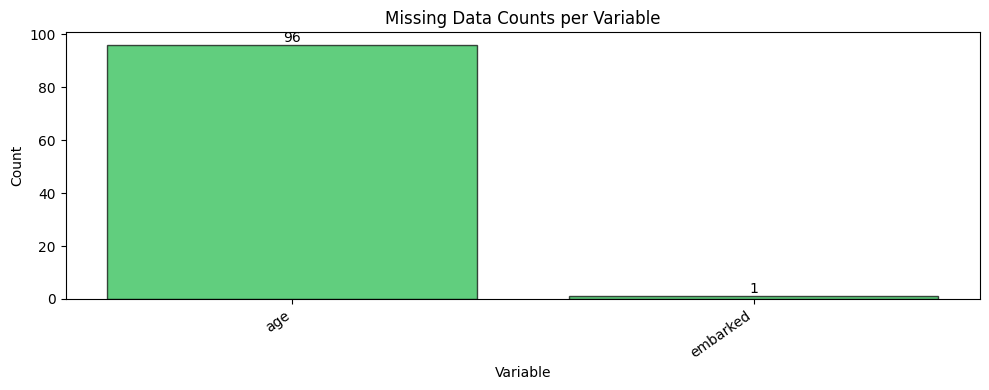

In [12]:
eda_helper_functions.plot_missing_info(df)

`age` and `embarked` have missing values

In [13]:
import missingno as msno


<Axes: >

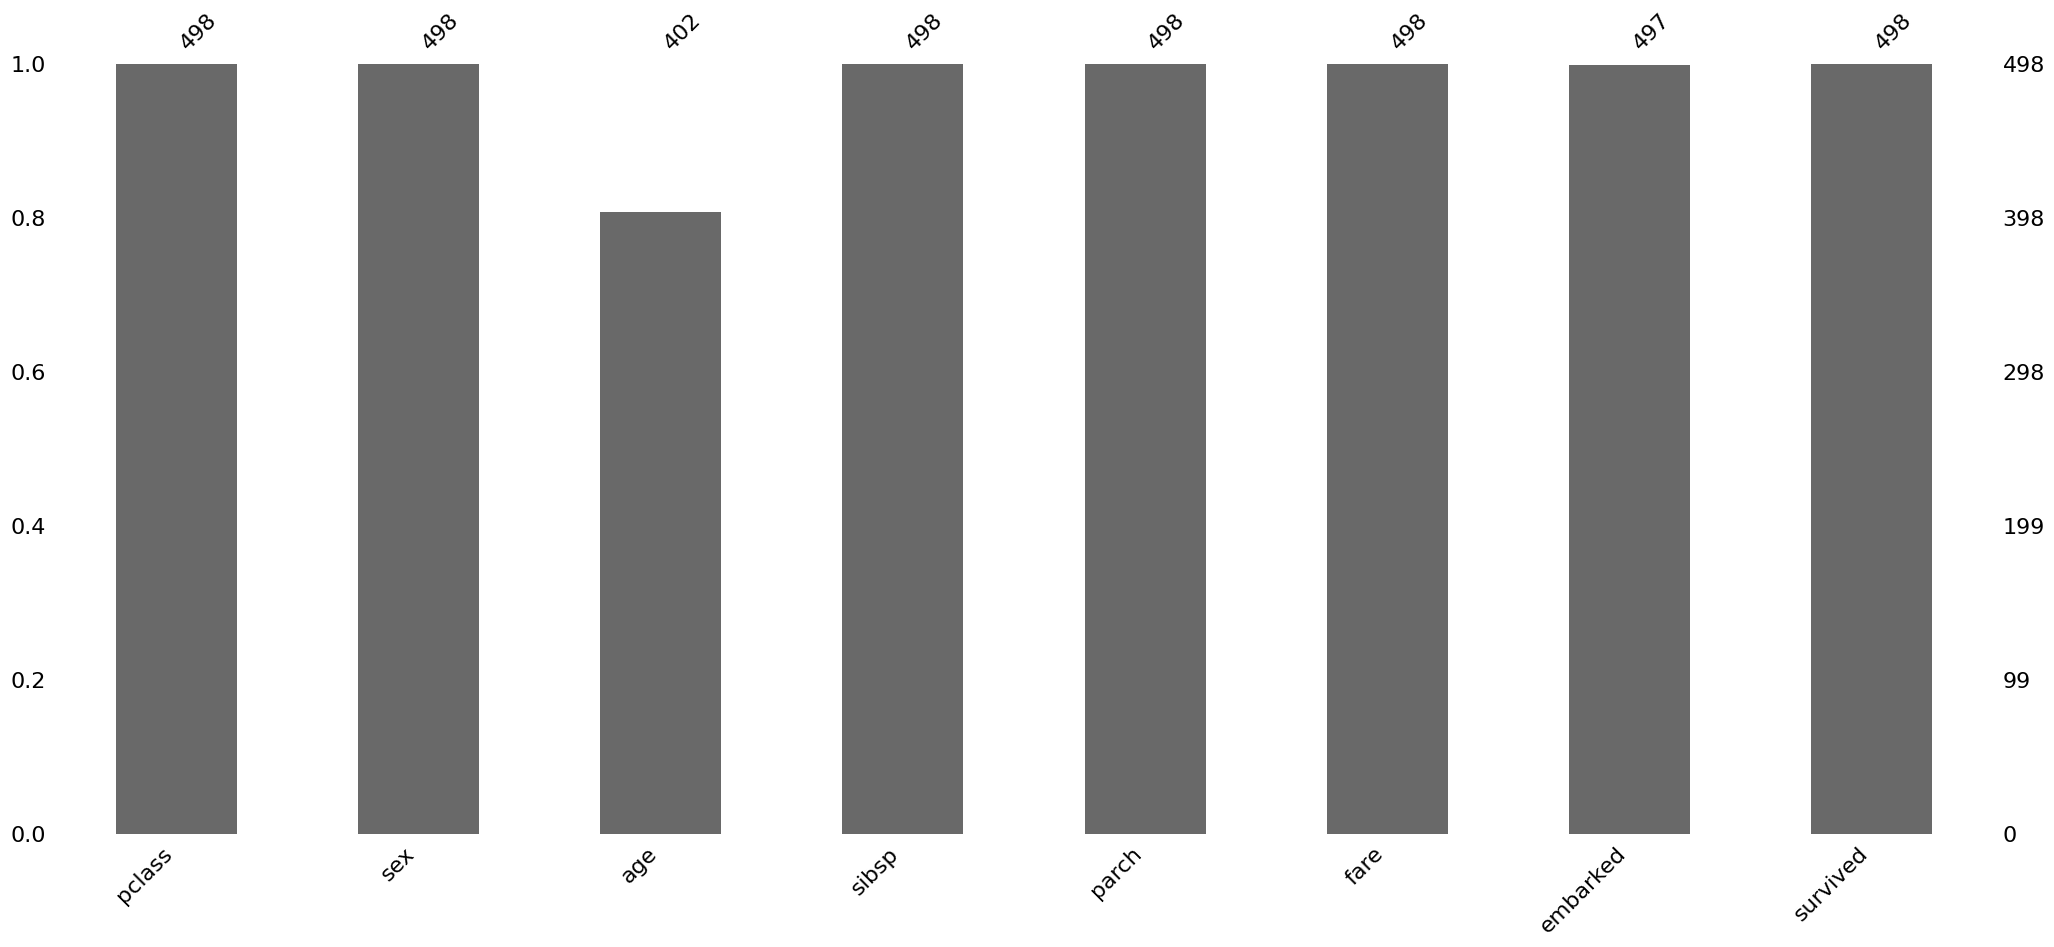

In [14]:
msno.bar(df)

<Axes: >

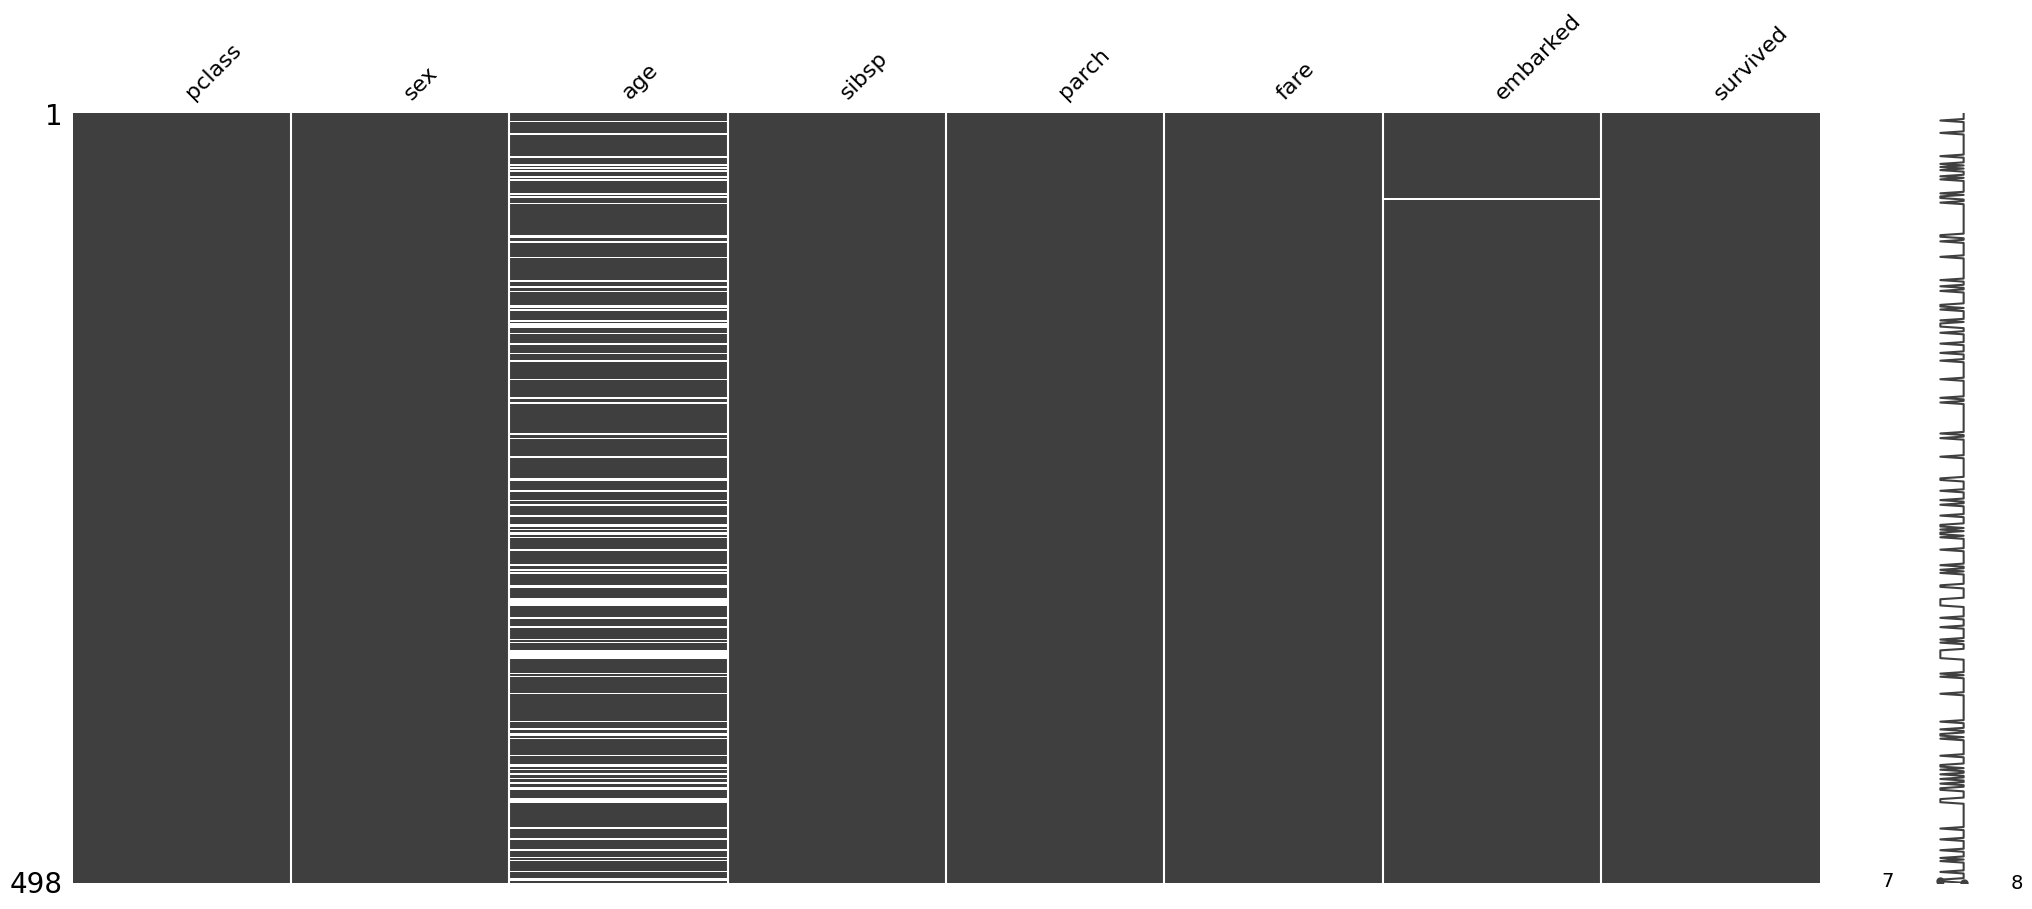

In [15]:
msno.matrix(df)

In [16]:
(
  df
  .assign(
    age_missing = lambda df_: df_.age.isnull().astype(int)
  )
  .groupby('pclass')
  .age_missing
  .mean()
)

pclass
1    0.109091
2    0.091743
3    0.265233
Name: age_missing, dtype: float64

3rd class passendgers have more missing values for `age` colm,
maybe coz they survived the least?  

In [17]:
(
  df
  .groupby('pclass')
  .survived
  .mean()
)

pclass
1    0.627273
2    0.449541
3    0.254480
Name: survived, dtype: float64

yes, they survived the least !! so cant say that missing values
of `age` colm depend on `pclass`

In [18]:
(  
  df
  .assign(
    missing_age = lambda df_: df_.age.isnull().astype(int)
  )
  .groupby('sex')
  .missing_age
  .mean()
)  

sex
female    0.169697
male      0.204204
Name: missing_age, dtype: float64

missing values of `age` dont depend on sex too
as both sex have similar missing values considering 
more male died than female 

In [19]:
(
  df
  .groupby('sex')
  .survived
  .mean()
)

sex
female    0.739394
male      0.201201
Name: survived, dtype: float64

In [20]:
df.sex.value_counts(normalize=True)*100

sex
male      66.86747
female    33.13253
Name: proportion, dtype: float64

In [21]:
df.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked',
       'survived'],
      dtype='object')

### 4. High level analysis of outliers

In [22]:
df.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked',
       'survived'],
      dtype='object')

for colms `age`, `sibsp`, `parch` nd `fare` it makes sense to check 
outliers      

In [23]:
iso = IsolationForest(n_estimators=100, random_state=12, contamination=0.05)

In [24]:
(
  df
  .assign(
    outlier = iso.fit_predict(
      df.drop(columns='survived')
      .select_dtypes(include='number')
    )
  )
  .outlier
  .value_counts()
)

outlier
 1    473
-1     25
Name: count, dtype: int64

In [25]:
(
  df
  .assign(
    outlier = iso.fit_predict(
      df.drop(columns='survived')
      .select_dtypes(include='number')
    )
  )
  .query("outlier==-1")
)

,pclass,sex,age,sibsp,parch,fare,embarked,survived,outlier
47,3,male,14.0,5,2,46.9000,S,0,-1
65,1,male,4.0,0,2,81.8583,S,1,-1
68,1,female,15.0,0,1,211.3375,S,1,-1
69,3,female,39.0,1,5,31.2750,S,0,-1
133,3,female,29.0,0,4,21.0750,S,0,-1
139,3,male,1.0,5,2,46.9000,S,0,-1
148,3,female,45.0,1,4,27.9000,S,0,-1
155,3,female,NaN,8,2,69.5500,S,0,-1
183,1,female,35.0,0,0,512.3292,C,1,-1
266,3,male,NaN,8,2,69.5500,S,0,-1


In [26]:
(
  df
  .assign(
    outlier = iso.fit_predict(
      df.drop(columns='survived')
      .select_dtypes(include='number')
    )
  )
  .query("outlier==-1")
  .describe()
)

,pclass,age,sibsp,parch,fare,survived,outlier
count,25.000000,19.000000,25.000000,25.000000,25.000000,25.000000,25.0
mean,2.160000,25.421053,3.200000,2.440000,125.177168,0.320000,-1.0
std,0.986577,16.084208,3.162278,1.356466,119.274198,0.476095,0.0
min,1.000000,1.000000,0.000000,0.000000,18.750000,0.000000,-1.0
25%,1.000000,15.500000,1.000000,2.000000,46.900000,0.000000,-1.0
50%,3.000000,24.000000,2.000000,2.000000,69.550000,0.000000,-1.0
75%,3.000000,37.000000,5.000000,3.000000,211.337500,1.000000,-1.0
max,3.000000,64.000000,8.000000,5.000000,512.329200,1.000000,-1.0


for 5% contamination value, got 25 outlier samples

### 5. Pair Plots 

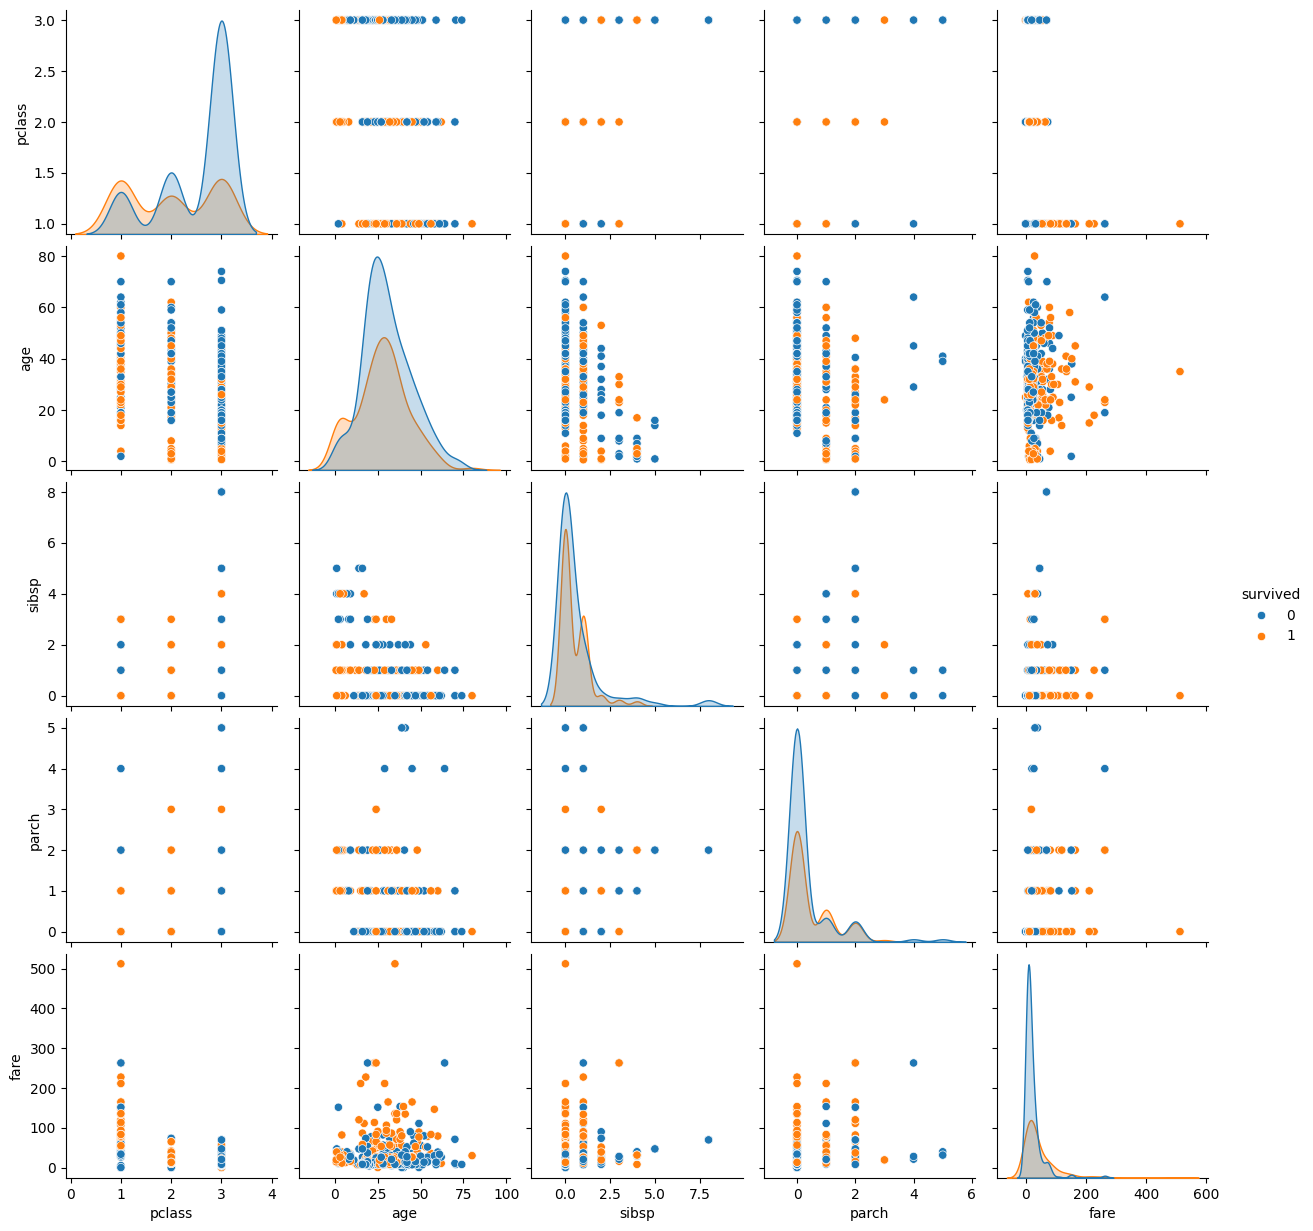

In [27]:
sns.pairplot(df, hue='survived')

In [28]:
(
  df
  .groupby('pclass')
  .fare
  .mean()
)

pclass
1    80.911819
2    21.021025
3    14.033466
Name: fare, dtype: float64

- lower the plcass, higher the fare

### 6. Co-relation analysis

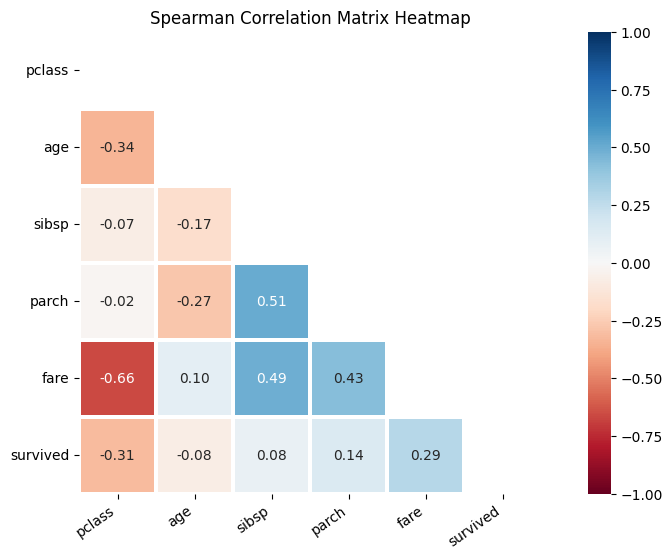

In [29]:
eda_helper_functions.correlation_heatmap(df) # only for numerical features

- pclass has -ve correlation with all features
- higher the number of parents nd children, higher the fare
- parch and sibsp r moderately co-related

In [30]:
(
  df
  .assign(
    fam_size = lambda df_: df_.sibsp + df_.parch + 1
  )
  .drop(columns=['parch', 'sibsp'])
  .groupby('fam_size')
  .survived
  .mean()
)

fam_size
1     0.312500
2     0.512500
3     0.563636
4     0.727273
5     0.000000
6     0.200000
7     0.428571
8     0.000000
11    0.000000
Name: survived, dtype: float64

- family sizes of '2', '3' have higher survival rates

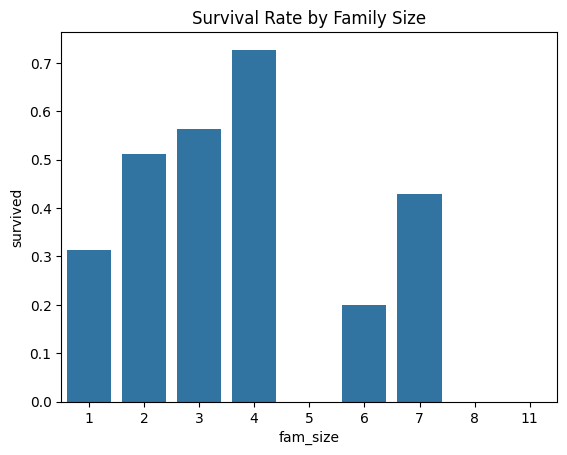

In [31]:
(                   
    df              
    .assign(fam_size = lambda d: d.sibsp + d.parch + 1)   # include self
    .pipe(lambda d: sns.barplot(x="fam_size", y="survived", data=d, errorbar=None))
)                   
plt.title("Survival Rate by Family Size")
plt.show()          

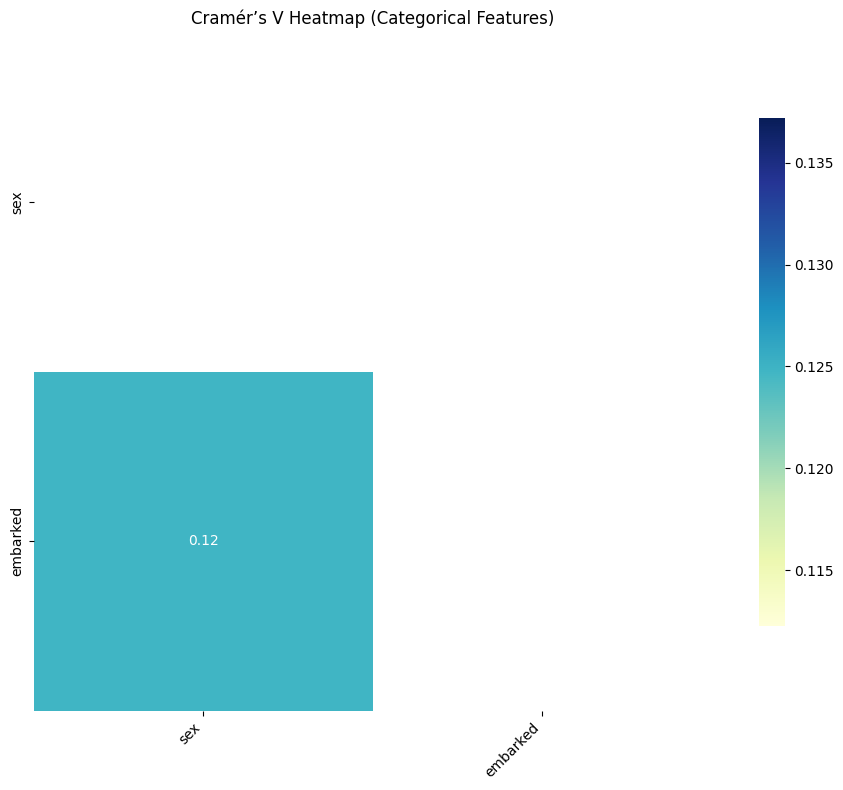

In [32]:
eda_helper_functions.my_plot_cramers_v_heatmap(df)


### 7. Detailed anaylsis (feature wise)

In [33]:
df.columns.tolist()

['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'survived']

7.1 `pclass`

In [34]:
df.pclass.value_counts()

pclass
3    279
1    110
2    109
Name: count, dtype: int64

In [35]:
df.pclass.dtype

dtype('int64')

In [36]:
(
 df
 .assign(pclass=df.pclass.astype(object))
 .pipe(lambda d: eda_helper_functions.cat_summary(d, "pclass")) 
)

0      1
1      3
2      3
3      3
4      3
      ..
493    2
494    3
495    2
496    3
497    1
Name: pclass, Length: 498, dtype: object

Data Type      : object
Cardinality    : 3 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 498 / 498 rows


,
count,498
unique,3
top,3
freq,279


,count,percentage
category,,
3,279,0.560241
1,110,0.220884
2,109,0.218876


In [37]:
# (    
#   df 
#   .assign(
#     pclass = lambda d: d.pclass.astype('category')
#   )  
#   .pipe(lambda d: eda_helper_functions.cat_univar_plots(d, "pclass"))
# )       

pclass = 3 have higher passengers

In [38]:
df.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked',
       'survived'],
      dtype='object')

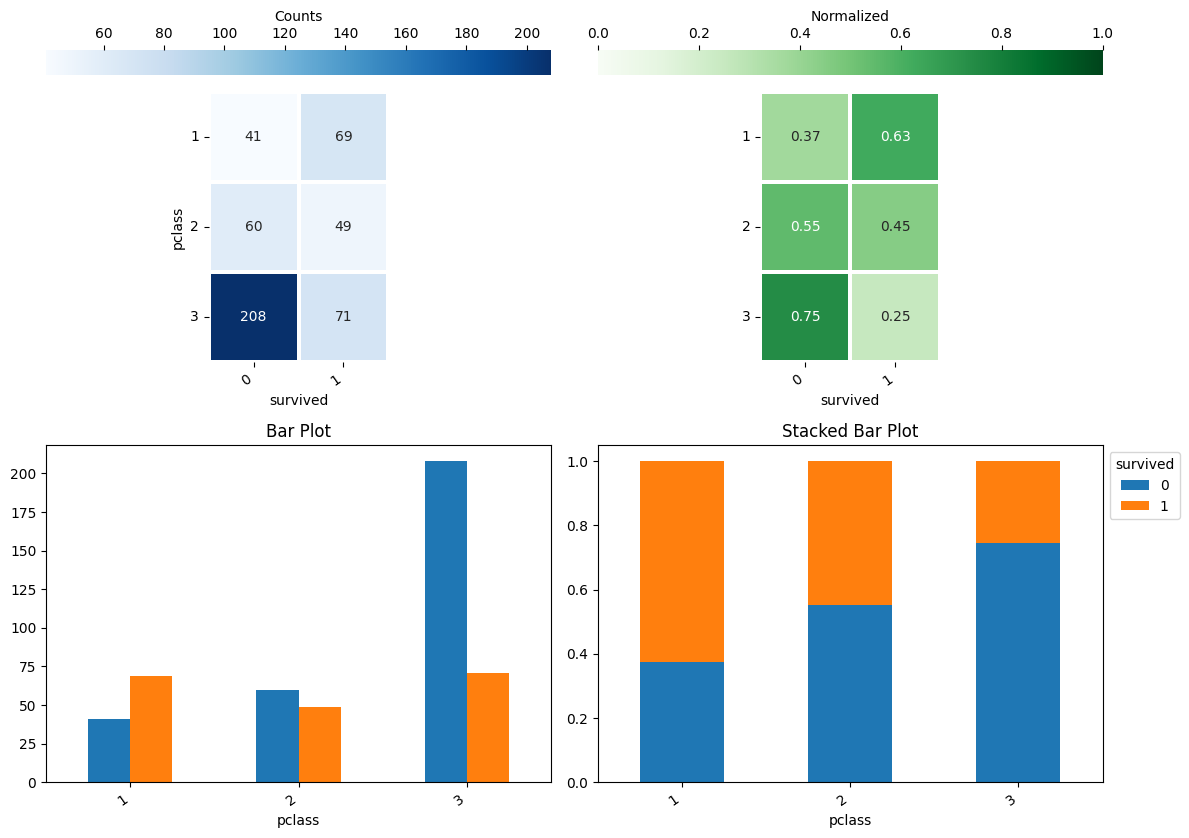

In [39]:
(
  df
  .assign(
    pclass = lambda d: d.pclass.astype('object')
  )
  .pipe(lambda d: eda_helper_functions.cat_bivar_plots(df, "pclass", "survived"))
)

as `pclass` increases, survival chances decreases

it looks a very good predictor for our target label i.e `survived`

no need to scale or convert into categorical 

In [40]:
(df
 .groupby(['pclass', 'sex'])
 .survived
 .mean()
)

pclass  sex   
1       female    0.940000
        male      0.366667
2       female    0.972222
        male      0.191781
3       female    0.506329
        male      0.155000
Name: survived, dtype: float64

In [41]:
(
  df
  .groupby(['sex', 'pclass'])
  .survived
  .mean()
  .unstack()
)

pclass,1,2,3
sex,,,
female,0.940000,0.972222,0.506329
male,0.366667,0.191781,0.155000


In [42]:
df.pivot_table(
  index = 'sex',
  columns='pclass',
  values = 'survived',
  aggfunc='mean'
)

pclass,1,2,3
sex,,,
female,0.940000,0.972222,0.506329
male,0.366667,0.191781,0.155000


In [43]:
df.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked',
       'survived'],
      dtype='object')

7.2 `sex`

In [44]:
df.sex.dtype

dtype('O')

In [45]:
eda_helper_functions.cat_summary(df, "sex")

0      female
1      female
2      female
3        male
4        male
        ...  
493      male
494      male
495      male
496      male
497    female
Name: sex, Length: 498, dtype: object

Data Type      : object
Cardinality    : 2 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 498 / 498 rows


,
count,498
unique,2
top,male
freq,333


,count,percentage
category,,
male,333,0.668675
female,165,0.331325


67 % are males and 33% females , need to think abt imbalance-ness here

also  encode this `sex` colm

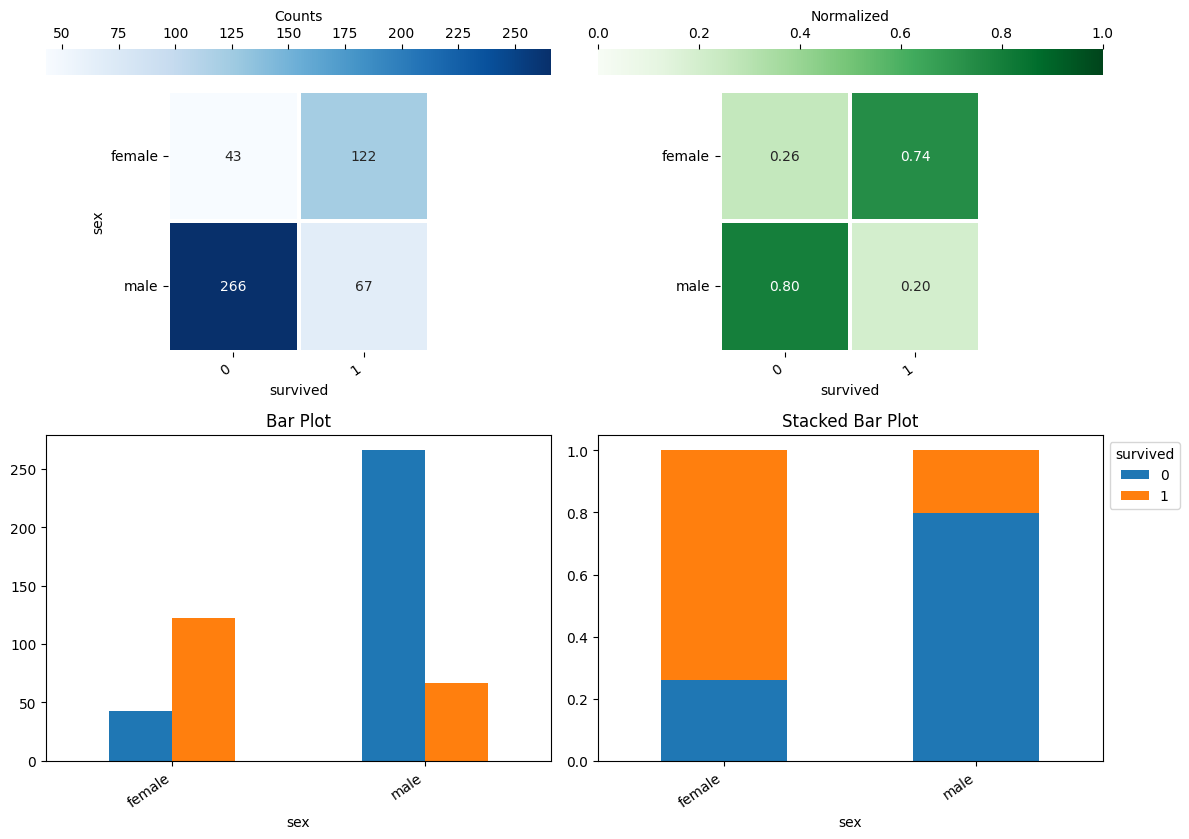

In [46]:
eda_helper_functions.cat_bivar_plots(df,"sex","survived")

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    498 non-null    int64  
 1   sex       498 non-null    object 
 2   age       402 non-null    float64
 3   sibsp     498 non-null    int64  
 4   parch     498 non-null    int64  
 5   fare      498 non-null    float64
 6   embarked  497 non-null    object 
 7   survived  498 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 31.3+ KB


`sex` and `survived` hv good relation

In [48]:
df.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked',
       'survived'],
      dtype='object')

7.3 `age`

In [49]:
df.age.dtype

dtype('float64')

In [50]:
eda_helper_functions.num_summary(df, "age")

0      24.0
1       3.0
2      16.0
3      32.0
4      22.0
       ... 
493    52.0
494    33.0
495     NaN
496     NaN
497    56.0
Name: age, Length: 498, dtype: float64

Data Type      : float64
Missing Data   : 96 rows (19.28 %)
Available Data : 402 / 498 rows


,value
percentile,
0,0.67
5,3.00
10,9.20
25,20.00
50,28.00
75,38.00
90,49.00
95,54.95
99,69.94


,value
mean,29.309701
trimmed mean (5%),NaN
trimmed mean (10%),NaN
median,28.000000


,value
var,214.506122
std,14.646028
IQR,18.000000
mad,9.000000
coef_variance,0.499699


,value
skewness,0.336265
kurtosis,0.275051


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 3.966548472220616e-05
Test Statistic       : 0.9810161181935427
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.779
Test Statistic       : 1.966090743725772
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


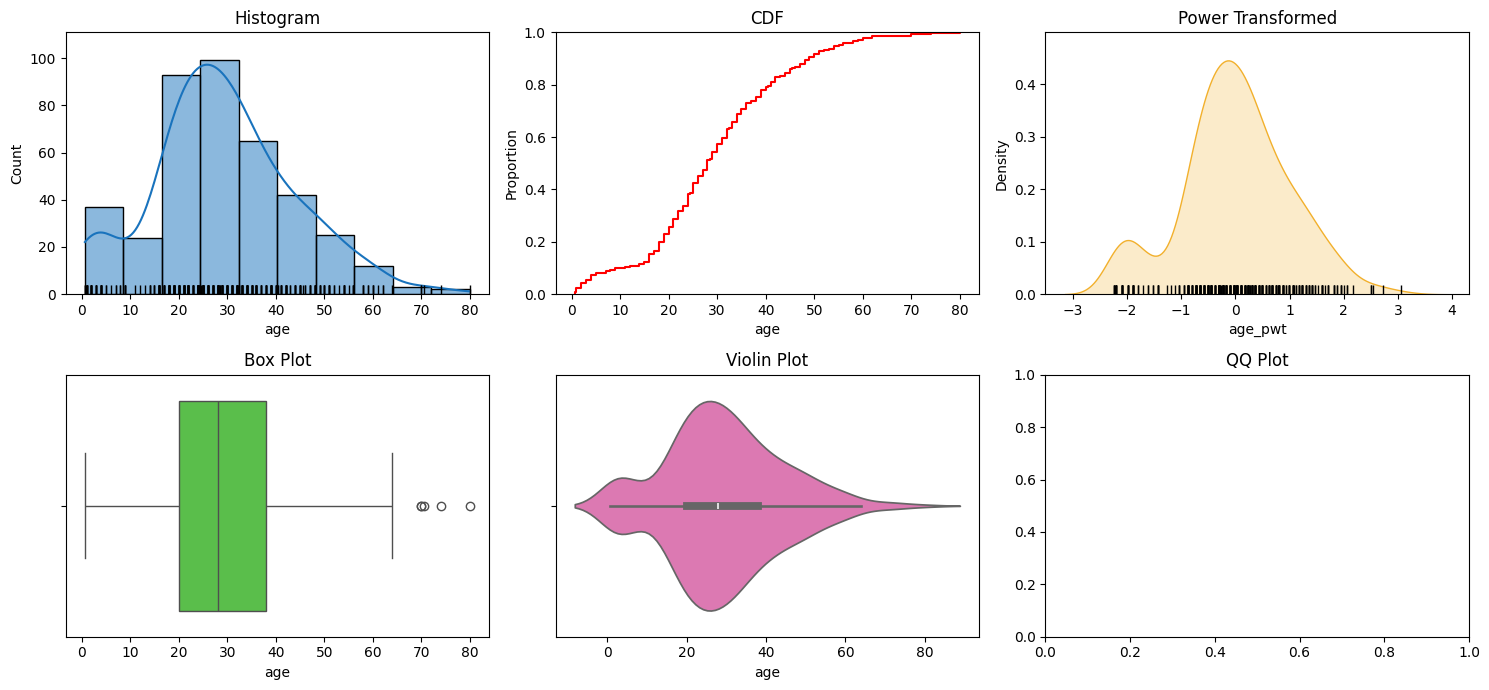

In [51]:
eda_helper_functions.num_univar_plots(df, "age")

`age` is right skewed and has outliers along with missing values

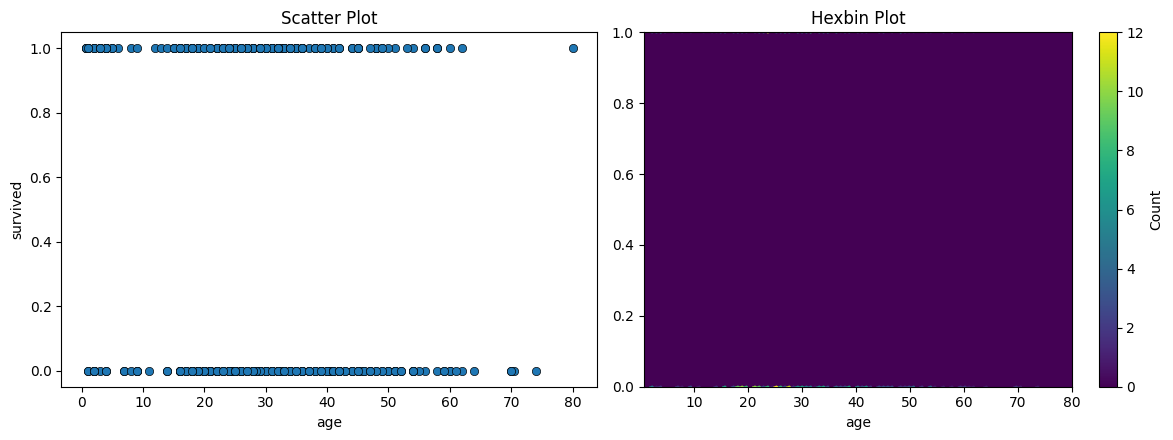

In [52]:
eda_helper_functions.num_bivar_plots(df, "age","survived")

In [53]:
df[df['age']<10].survived.mean()

np.float64(0.6097560975609756)

In [54]:
df[df['age'] < 10].survived.value_counts(normalize=True)


survived
1    0.609756
0    0.390244
Name: proportion, dtype: float64

In [55]:
df[df['age']>35].survived.mean()

np.float64(0.3559322033898305)

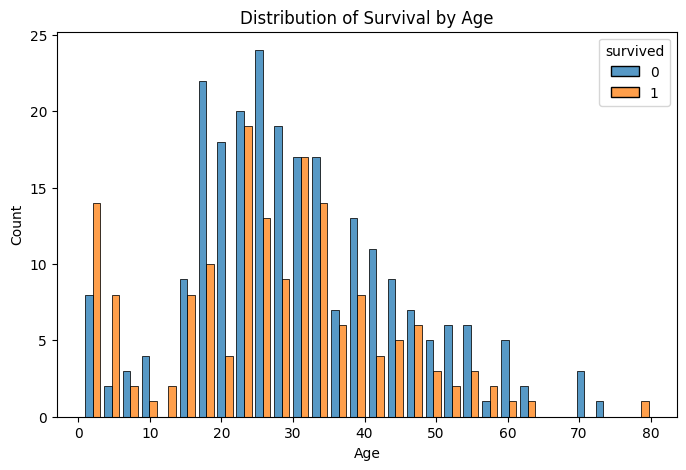

In [56]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='age', hue='survived', bins=30, multiple='dodge', shrink=0.8)
plt.title("Distribution of Survival by Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


- `age` has missing values 
- since median < mean, its right skewed i.e skewness > 0
- Impute missing Age values (e.g., median age grouped by Pclass + Sex).

#### 7.3.1 Age(missing values)

Always decide imputation strategy during EDA,
but fit imputers only on train data to avoid leakage.

👉 Outliers are only checked after missing values are identified, because otherwise a missing 
value could trick you (e.g., if someone coded missing as Age = 999).

✅ So the order is:

Step 1: Check missing values → know how bad the problem is.

Step 2: Check outliers → see if extreme values distort the data.

Step 3: Fill missing values (using median/mean/etc.) → but only after you’ve handled obvious outliers.

In [57]:
(df[df.age>80].shape[0]/ df.shape[0])*100

0.0

Note: cap age values > 80 to 80 

In [58]:
(
  df
  .assign(
    age_missing = lambda d:  d.age.isnull().astype(int)
  )
  .groupby('pclass')
  .age_missing
  .mean()
  
)

pclass
1    0.109091
2    0.091743
3    0.265233
Name: age_missing, dtype: float64

#### 7.3.2 Finding imputing strategy for `age` colm

Note : cap all values > 80 for age colm to 80
Methods are 
- Remove rows with missing values 
- Simple Imputer 
- KNN imputer
- Iterative Imputer 
- Missing Indicator 

missing value imputation 
- did capping for `age` > 70 to 70 
- median imputation as per `pclass`


In [59]:
(   
  df    
  .assign(age = lambda d: d.age.clip(upper=70))
  .groupby('pclass')
  .age  
  .transform(
    lambda x: x.fillna(x.median())
  )     
  .isnull()
  .sum()
)          

np.int64(0)

checking below if numbers > 70 r now in `age` colm

In [60]:
(
  df
  .assign(
    age = lambda d: (
      d
      .age
      .clip(upper=70)
      .groupby(d.pclass)
      .transform(
        lambda d: d.fillna(d.median())
      )
    )
  )
  .query("age>70") # query works only on data frame 
)

,pclass,sex,age,sibsp,parch,fare,embarked,survived


Quick numeric checks (no listing of rows)

In [61]:
(
  df
  .assign(
    age = lambda d: (
      d
      .age
      .clip(upper=80)
      .groupby(d.pclass)
      .transform( 
        lambda d: (
          d.fillna(d.median())  
        )
      )
    )
  )
  .age
  .gt(70)  
)

0      False
1      False
2      False
3      False
4      False
       ...  
493    False
494    False
495    False
496    False
497    False
Name: age, Length: 498, dtype: bool

In [62]:
(
  df
  .assign(
    age = lambda d: (
      d
      .age
      .clip(upper=80)
      .groupby(d.pclass)
      .transform( 
        lambda d: (
          d.fillna(d.median())  
        )
      )
    )
  )
  .age
  .gt(80) 
  .sum() 
)

np.int64(0)

- ✨ So your mental model should be:
- assign: DataFrame level
- transform: column/group level (Series)

knn imputer method 

- ⚠️ KNNImputer only works with numeric columns.


In [63]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer()

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    498 non-null    int64  
 1   sex       498 non-null    object 
 2   age       402 non-null    float64
 3   sibsp     498 non-null    int64  
 4   parch     498 non-null    int64  
 5   fare      498 non-null    float64
 6   embarked  497 non-null    object 
 7   survived  498 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 31.3+ KB


- 👉 Outliers only make sense for numeric features (continuous or ordered).

-  So, the order is:
  👉 For each numerical column:
  Look at % missing.
  Look at outliers (only on valid values).
  Fix outliers (drop/cap).
  Then impute missing values sensibly (median, KNN, regression, etc.).

doing outlier analysis for `age` colm using isolation forest 

In [65]:
# (
#   df
#   .assign(
#     outlier = iso.fit_predict(
#       df.drop(columns='survived')
#       .select_dtypes(include='number')
#     )
#   )
#   .outlier
#   .value_counts()
# )

In [66]:
from sklearn.ensemble import IsolationForest
  
iso = IsolationForest(contamination=0.05, random_state=42)
  
( 
  df
  .assign(
    age_iso = lambda d: pd.Series(
        iso.fit_predict(d[['age']].dropna()), 
        index=d['age'].dropna().index   # align back with df
    )
  )
  .query("age_iso==-1")
  
) 


,pclass,sex,age,sibsp,parch,fare,embarked,survived,age_iso
32,1,male,70.00,1,1,71.0000,S,0,-1.0
75,2,male,62.00,0,0,10.5000,S,1,-1.0
76,3,male,12.00,1,0,11.2417,C,1,-1.0
99,3,male,70.50,0,0,7.7500,Q,0,-1.0
171,3,male,6.00,0,1,12.4750,S,1,-1.0
208,3,male,7.00,4,1,29.1250,Q,0,-1.0
223,2,female,5.00,1,2,27.7500,S,1,-1.0
263,3,female,0.75,2,1,19.2583,C,1,-1.0
275,2,male,70.00,0,0,10.5000,S,0,-1.0
277,3,male,11.00,0,0,18.7875,C,0,-1.0


iqr analysis of `age` colm

In [67]:
# 95th percentile
p95 = df['age'].quantile(0.95)

# Quartiles
q1 = df['age'].quantile(0.25)
q3 = df['age'].quantile(0.75)

# IQR
iqr = q3 - q1

# Outlier thresholds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print("95th percentile:", p95)
print("Q1:", q1, "Q3:", q3, "IQR:", iqr)
print("Lower bound:", lower_bound, "Upper bound:", upper_bound)


95th percentile: 54.94999999999999
Q1: 20.0 Q3: 38.0 IQR: 18.0
Lower bound: -7.0 Upper bound: 65.0


for outlier analysis we can do the follwing : 
- cap 
- flag 
- transform 
- make NaN and impute with KNN 

`age` colm outlier analysis using 
- ISO ->
- flagging ->
- imputing using KNN

In [68]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.05, random_state=42)  
( 
  df
  .assign(
    age_iso = lambda d: pd.Series(
        iso.fit_predict(d[['age']].dropna()), 
        index=d['age'].dropna().index   # align back with df
    )
  )
  .query("age_iso==-1")
  .shape
) 


(20, 9)

using iso i get outliers -> make a flag colm -> knn imputer 
note for knn: encode  `sex` using ohe 

In [80]:
(
  df
  .pipe(lambda d: pd.get_dummies(d, columns=['sex'],drop_first=True,  dtype=int))
  .assign(
    age_iso = lambda d: pd.Series(
        iso.fit_predict(d[['age']].dropna()), 
        index=d['age'].dropna().index   # align back with df
    )
  )
  .age_iso
  .value_counts()
)

age_iso
 1.0    382
-1.0     20
Name: count, dtype: int64

working on above 

In [85]:
knn_imputer = KNNImputer(n_neighbors=5)

In [88]:
df[df.drop(columns='survived').select_dtypes(include='number').columns]

,pclass,age,sibsp,parch,fare
0,1,24.0,0,0,69.3000
1,3,3.0,3,1,21.0750
2,3,16.0,0,0,7.7333
3,3,32.0,0,0,56.4958
4,3,22.0,0,0,7.1250
...,...,...,...,...,...
493,2,52.0,0,0,13.5000
494,3,33.0,1,1,20.5250
495,2,NaN,0,0,13.0000
496,3,NaN,8,2,69.5500


In [92]:
(
  df
  .pipe(lambda d: pd.get_dummies(d, columns=['sex'], drop_first=True, dtype=int))
  .assign(
    age_iso = lambda d: pd.Series(
        iso.fit_predict(d[['age']].dropna()),
        index=d['age'].dropna().index
    ),
    age_outlier = lambda d: (d.age_iso == -1).astype(int)
  )
  .drop(columns=['age_iso'])
  .pipe(
    lambda d: d.assign(
        age = pd.Series(
            knn_imputer.fit_transform(
                d.drop(columns='survived').select_dtypes(include='number')
            )[:, d.drop(columns='survived').columns.get_loc('age')],
            index=d.index
        )
    )
  )
)


,pclass,age,sibsp,parch,fare,embarked,survived,sex_male,age_outlier
0,1,24.0,0,0,69.3000,C,1,0,0
1,3,3.0,3,1,21.0750,S,0,0,0
2,3,16.0,0,0,7.7333,Q,1,0,0
3,3,32.0,0,0,56.4958,S,1,1,0
4,3,22.0,0,0,7.1250,S,0,1,0
...,...,...,...,...,...,...,...,...,...
493,2,52.0,0,0,13.5000,S,0,1,0
494,3,33.0,1,1,20.5250,S,0,1,0
495,2,26.6,0,0,13.0000,S,1,1,0
496,3,37.2,8,2,69.5500,S,0,1,0


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
iso = IsolationForest(contamination=0.05, random_state=42)
imputer = KNNImputer(n_neighbors=5)
( 
  df
  .assign(
    age_iso = iso.fit_predict(
      df[['age']]
    ),
    age_outlier = lambda d: (
      (d.age_iso==-1).astype(int)
    ),
    sex = df.sex.map
  )
  .drop(columns='age_iso')  
  .fit_transform(df[['age', 'age_outlier', 'pclass',]])
) 


AttributeError: 'Series' object has no attribute 'imputer'

In [ ]:
num_cols = ['pclass', 'age', 'sibsp', 'parch']

7.4 `sibsp` & `parch`

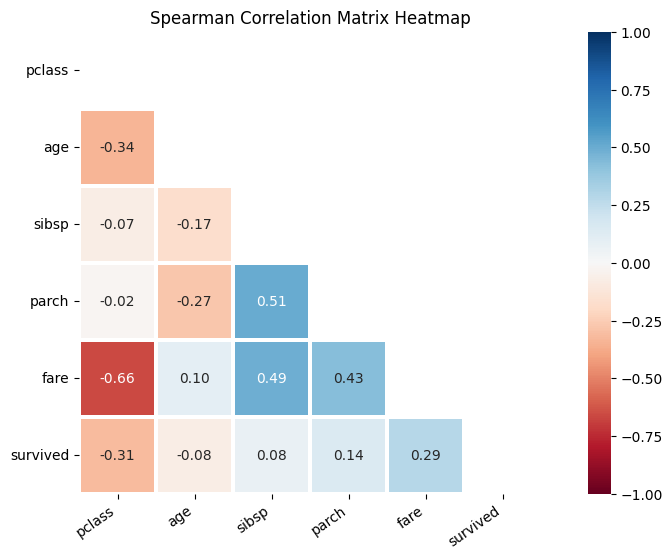

In [ ]:
eda_helper_functions.correlation_heatmap(df)

In [ ]:
(
  df
  .assign(
    family_size = lambda d: d.parch + d.sibsp + 1
  )
  .drop(columns=['parch', 'sibsp'])
)

,pclass,sex,age,fare,embarked,survived,family_size
0,1,female,24.0,69.3000,C,1,1
1,3,female,3.0,21.0750,S,0,5
2,3,female,16.0,7.7333,Q,1,1
3,3,male,32.0,56.4958,S,1,1
4,3,male,22.0,7.1250,S,0,1
...,...,...,...,...,...,...,...
493,2,male,52.0,13.5000,S,0,1
494,3,male,33.0,20.5250,S,0,3
495,2,male,NaN,13.0000,S,1,1
496,3,male,NaN,69.5500,S,0,11


Observations
 1. `sex` and `embarked` are both imbalanced colms, handle imbalance
 2. `age` and `embarked` have missing values
 3.  for colms `age`, `sibsp`, `parch` nd `fare` it makes sense to check 
outliers      